In [1]:
# Import Libraries
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import json
import re
import fa2
import math
import community
import matplotlib.cm as cm
from __future__ import division
import matplotlib.image as mpimg
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import io
from collections import Counter
from wordcloud import WordCloud
# Rendering Parameters
title_font = {'family': 'sans-serif',
        'color':  '#000000',
        'weight': 'normal',
        'size': 16,
        }

## Sentiment Scores
To calculate sentiment scores, we used the naive sentiment algorithm as described in [Dodds, 2011]. The sentiment is calculated as the sum of the sentiments scores of each word in the reviews multiplied by the frequency of that word if the word has a defined score which is defined as 
![alt text](https://journals.plos.org/plosone/article/file?type=thumbnail&id=info:doi/10.1371/journal.pone.0064417.e007 "Sentiment Score")
This sentiment for individual words are used as in [Dodds, 2011] with 11000 words where 50 humans have evaluated the words sentiment.

This analysis is simply to look at the distribution of these scores for each review to see what prior is represented in the data.

We defined a function that takes dictionaries due to look-up efficiency.

In [2]:
#Loading
dict_to_compare = {}
newfile = io.open("Data_Set_S1.txt", mode="r", encoding="utf-8")
count = 0
for row in newfile:
    if count < 4:
        count +=1
        continue
        
    string = row.split("\t")
    dict_to_compare[string[0]] = float(string[2])

def happiness(dict_of_tokens,dict_to_compare):
    #dict_of_tokens is the tokenized dictionary with their count (token: count)
    #dict_to_compare is a dictionary that contains word as key and the averaged_happiness_weight as value
    #Return 0 if no tokens
    if len(dict_of_tokens)==0:
        return 0
    #Sum of token frequency multiplied with the averaged_happiness_weight as in (1) from the paper[Dodds, 2011]
    keys = [key for key in dict_of_tokens if key in dict_to_compare.keys()]
    #Normalization can only be calculated after keys since "for which we have an estimate of average happiness"[Dodds, 2011] applies
    normalization = sum(dict_of_tokens[key] for key in keys)
    #Return 0 if no word is present in dict_to_compare
    if normalization==0:
        return 0
    sums = sum(dict_to_compare[key]*dict_of_tokens[key] for key in keys)
    return sums/normalization

Just some data loading. You need to download the folder structure as of https://www.kaggle.com/iarunava/imdb-movie-reviews-dataset.
We used regular expressions to find the IMDb id in each file and match it with their patch, so the sentiment could be stored correctly.

In [3]:
#Create dictionaries for sentiment and reviews matching index in Large Movie Review Dataset
moviereviews = {}
moviesentement = {}
#Initialize sentiment and load index for movies in Large Movie Review Dataset
for filename in os.listdir("aclImdb/test"):
    if filename.endswith(".txt"):
        text = re.findall("urls_(\w*).txt",filename)
        with open("aclImdb/test/"+filename) as file:
            for idx,line in enumerate(file):
                ID = re.findall("http://www.imdb.com/title/(\w*)/usercomments",line)
                moviereviews[(idx,"test/"+text[0])] = ID[0]
                moviesentement[ID[0]] = [0,0]
#Same as above for other directory
for filename in os.listdir("aclImdb/train"):
    if filename.endswith(".txt"):
        text = re.findall("urls_(\w*).txt",filename)
        with open("aclImdb/train/"+filename) as file:
            text = re.findall("urls_(\w*).txt",filename)
            for idx,line in enumerate(file):
                ID = re.findall("http://www.imdb.com/title/(\w*)/usercomments",line)
                moviereviews[(idx,"train/"+text[0])] = ID[0]
                moviesentement[ID[0]] = [0,0]

Tokenize the reviews and calculate the weighted sentiment score. Sentiment score for same movie is added to the movie and the count of reviews for the movie is also recorded. We use io.open to handle unicode exceptions and use regular expressions to filter websites, HTML formatting and tags in the reviews. The analysis takes around 45 minuttes. Scores are stored independently to see the statistics of the reviews themselves.

In [4]:
#Define tokens, stopwords and path
stopwordslist = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')
paths = ["train/unsup","train/pos","train/neg","test/neg","test/pos"]
scores = []
for path in paths:
    done = len(os.listdir("aclImdb/"+path))
    for idx,filename in enumerate(os.listdir("aclImdb/"+path)):
        file = io.open("aclImdb/"+path+"/"+filename, mode="r", encoding="utf-8")
        string = file.readlines()[0]
        #Strip for websites, tags and HTML formatting
        w = re.findall(r'@\w*', string)
        for i in range(0, len(w)):
            string = string.replace(w[i], "")
        w = re.findall('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+[\/\w+]*', string)
        for i in range(0, len(w)):
            string = string.replace(w[i], "")
        w = re.findall("<[^>]*>",string)
        for i in range(0, len(w)):
            string = string.replace(w[i], "")
        string = re.sub(r'\d+', '', string)
        #Set to lowercase and tokenize
        string = string.lower()
        filtered = tokenizer.tokenize(string)
        #Remove stopwords
        filtered = [w for w in filtered if w not in stopwordslist]
        review = Counter(filtered)
        #Calculate sentiment
        score = happiness(review,dict_to_compare)
        moviesentement[moviereviews[(idx,path)]][0] += 1
        moviesentement[moviereviews[(idx,path)]][1] += score
        scores.append(score)
        #Progress bar due to VERY large dataset
        if idx/done*100%10==0:
            print("Done with {0}% in the corresponding folder {1}.".format(idx/done*100,path))

We save the file of the movie sentiment to another analysis to be used later.

In [5]:
#Save to file so process does not have to be repeated
with open('sentiment.txt', 'w') as file:
     file.write(json.dumps(moviesentement))

In [6]:
#---------------------
# HISTOGRAM FUNCTION FOR CONTINUES VALUES
#---------------------

def histogramCont(degrees,nb_bins):
    # Computing Bins
    min_bin = np.amin(degrees)
    max_bin = np.amax(degrees)
    
    #Hist
    hist, bin_edges = np.histogram(degrees,bins = nb_bins+1)
    return hist, bin_edges

Histogram for a distribution of the sentiment.

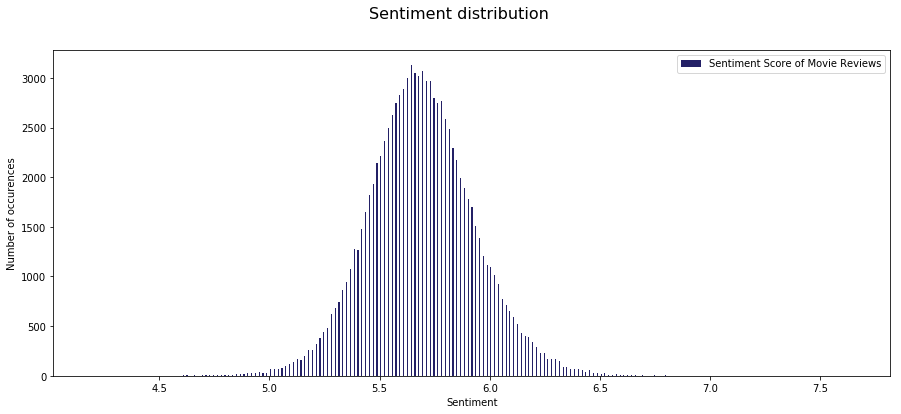

Average of average weighted happiness in review: 5.698057216744183
Standard deviation of average weighted happiness in review: 0.24207052989735794


In [7]:
Blue = "#232066"
nbins= 200
# Get the histograms
hist, bins = histogramCont(scores,nbins)
plt.figure(figsize = (15,6))
plt.bar(bins[:-1], hist, 1/nbins, color=Blue, label = "Sentiment Score of Movie Reviews") #0 exlcuded due to no sentiment
plt.xlabel('Sentiment')
plt.ylabel('Number of occurences')
plt.suptitle('Sentiment distribution', fontsize=16)
plt.legend()
plt.savefig("Figures/SentimentHistogram.svg")
plt.savefig("Figures/SentimentHistogram.jpeg")
plt.savefig("Figures/SentimentHistogram.png")
plt.savefig("Figures/SentimentHistogram.pdf")
plt.show()
print "Average of average weighted happiness in review: " + str(np.mean(scores))
print "Standard deviation of average weighted happiness in review: " + str(np.std(scores))

Now we have gotten to the end of this analysis step. We clearly see a normal distribution of the reviews. Since this dataset had to have balance, the selection criteria for the reviews biases the reviews in such way. This can affect both the sentiment as edge weight for the community analysis and what frequent words appear for negative and positive reviews.

## Frequent words for positive and negative reviews
Now that the scores has been determined, we can sort the reviews in positive and negative reviews. If we set the bar to a sentiment score of $\mu\pm2\sigma$, we get around $2.5\%$ most positive and $2.5\%$ most negative reviews since the empirical prior is normal.
When these reviews are sorted, we can compare the tokens of all positive and negative reviews the Term Frequency - Inverse Document Frequency (TF-IDF). 
TF is defined as
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/91699003abf4fe8bdf861bbce08e73e71acf5fd4 "Term Frequency")
where $f_t$ is the number of occurences of the word in a document. IDF is defined as
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/864fcfdc0c16344c11509f724f1aa7081cf9f657 "Inverse Document Frequency")
where $N$ is the number of documents and $n_t$ is the number of occurences of the term in the $N$ documents.
TF-IDF makes sense since the frequent words in both negative and positive reviews are excluded.
These TF-IDFs for the tokens can then be included in a word cloud to represent the positive and negative tokens.

Loading the reviews again but this time sorting them in positive and negative reviews. Same preprocessing as before.

In [8]:
positiveReviews = []
negativeReviews = []
mu = np.mean(scores)
sig = np.std(scores)
for path in paths:
    done = len(os.listdir("aclImdb/"+path))
    for idx,filename in enumerate(os.listdir("aclImdb/"+path)):
        file = io.open("aclImdb/"+path+"/"+filename, mode="r", encoding="utf-8")
        string = file.readlines()[0]
        #Strip for websites, tags and HTML formatting
        w = re.findall(r'@\w*', string)
        for i in range(0, len(w)):
            string = string.replace(w[i], "")
        w = re.findall('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+[\/\w+]*', string)
        for i in range(0, len(w)):
            string = string.replace(w[i], "")
        w = re.findall("<[^>]*>",string)
        for i in range(0, len(w)):
            string = string.replace(w[i], "")
        string = re.sub(r'\d+', '', string)
        #Set to lowercase and tokenize
        string = string.lower()
        filtered = tokenizer.tokenize(string)
        #Remove stopwords
        filtered = [w for w in filtered if w not in stopwordslist]
        review = Counter(filtered)
        #Calculate sentiment
        score = happiness(review,dict_to_compare)
        #Sort in negative and positive reviews
        if score <=(mu-2*sig):
            negativeReviews=np.concatenate((negativeReviews,filtered))
        elif score>=(mu+2*sig):
            positiveReviews = np.concatenate((positiveReviews,filtered))
        #Progress bar due to VERY large dataset
        if idx/done*100%10==0:
            print("Done with {0}% in the corresponding folder {1}.".format(idx/done*100,path))

Defining a function for the TF-IDF. A lot of comprehensions for speed-up.

In [10]:
def TFIDF(doc, docs_to_compare):
    #Doc is the document (dict with count as value) for which TDIDF is caluclated
    #docs_to_compare is a list of documents (same format as above) to be compared with
    length = float(sum(doc.values()))
    #Dual comprehension for speedup (casted to C)
    return Counter({key: float(value)/length*math.log(float(len(docs_to_compare)+1)/float(1+sum(1 for docs in docs_to_compare if key in docs.keys()))) for key,value in doc.items()})

In [11]:
#TF-IDF
NegativeCounter = Counter(negativeReviews)
PositiveCounter = Counter(positiveReviews)
NegativeTFIDF = TFIDF(NegativeCounter,[PositiveCounter])
PositiveTFIDF = TFIDF(PositiveCounter, [NegativeCounter])

Defining WordClouds

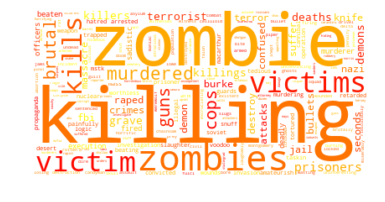

In [32]:
#Wordclouds
wordcloud = WordCloud(background_color='white',colormap = "autumn")
wordcloud.generate_from_frequencies(frequencies=NegativeTFIDF)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("Figures/NegativeCloud.svg")
plt.savefig("Figures/NegativeCloud.jpeg")
plt.savefig("Figures/NegativeCloud.png")
plt.savefig("Figures/NegativeCloud.pdf")
plt.show()

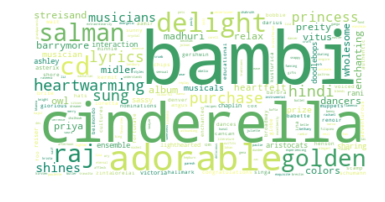

In [82]:
#Wordclouds
wordcloud = WordCloud(background_color='white', colormap="summer")
wordcloud.generate_from_frequencies(frequencies=PositiveTFIDF)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("Figures/PositiveCloud.svg")
plt.savefig("Figures/PositiveCloud.jpeg")
plt.savefig("Figures/PositiveCloud.png")
plt.savefig("Figures/PositiveCloud.pdf")
plt.show()

An interesting thing we note when the reviews are filtered for each other is that the positive sentiment tokens represent Disney movies and musicals! Negative sentiment represent horror and action movies. Thus the extremes of the reviews does not reflect if the movie is really good or really bad but more what genre it is. We did not expect this, however it makes a lot of sense. Sentiment for typical horror franchices is rated negatively and thus the review is reflected. Think of the following horror review; "This movie is so scary and creepy!". Not exactly the best sentiment will come out of the review. But is this a bad review for a horror movie? This calls for another analysis!

## Correlation of rating and sentiment
Due to previous analysis indicated that review sentiment represented genres more than if the movie was good or bad, we wanted to analyze the correlation of the rating and the sentiment of the movie.
Due to some movies also are represented less, we wanted to weight the sentiment of the movies as well to see if that has an effect on the correlation. 

Load of movie ratings. This is done as when the graph was made.

In [33]:
###################################
# Initialise a movie dictionnary
###################################

# Function. to convert movie or actor id to sting key
def idToString(iD, base): # base = "tt" for movies or "nm" for actors
    if iD<10:
        return base+"000000"+str(iD)
    if iD<100:
        return base+"00000"+str(iD)
    if iD<1000:
        return base+"0000"+str(iD)
    if iD<10000:
        return base+"000"+str(iD)
    if iD<100000:
        return base+"00"+str(iD)
    if iD<1000000:
        return base+"0"+str(iD)
    else:
        return base+str(iD)
    
# Create movie dictionnary
movieDict = {}
lastMovie = 9999999 #last movie ID
for i in range(lastMovie):
    movieDict[idToString(i+1,"tt")] = False

In [34]:
###################################
# Get the movies to keep
###################################

# List of the reviews documents
listReviewsDocuments = ["train/urls_neg.txt","test/urls_neg.txt","train/urls_pos.txt","test/urls_pos.txt","train/urls_unsup.txt"]

# Fill in the dictionnary
for document in listReviewsDocuments:
    files = io.open("aclImdb/"+document, mode="r", encoding="utf-8")
    for row in files:
        w = re.findall(r'http://www.imdb.com/title/(\w*)/usercomments',row)
        movieDict[w[0]] = True

In [35]:
###################################
# key to movie name file
###################################

movieAgeDict = {}
path = "DATA/title.basics.clean.txt"
files = io.open(path, mode="r", encoding="utf-8")
count =0
for row in files:
    split=row.split("\t")
    key = split[0]
    if movieDict[key]:
        if (split[1] in ['movie', 'tvMovie']) and not (split[5] == "\\N"):
            movieAgeDict[key] = int(split[5])
            count +=1
files.close()
        
#Clean Movie dict
for i in range(lastMovie):
    movieDict[idToString(i+1,"tt")] = False

count2 =0    
for key in movieAgeDict.keys():
    movieDict[key]=True
    count2 +=1


print "There are "+str(count)+" movies considered"
print str(count2)

There are 10735 movies considered
10735


In [36]:
###################################
# Create a ratings dict
###################################
ratingDict = {}
path = "DATA/ratings.txt"
files = io.open(path, mode="r", encoding="utf-8")
count = 0
i=False # skip first line
for row in files:
    if i:
        key = row[:9]
        if movieDict[key]:
            split = row.split("\t") 
            ratingDict[key] = float(split[1])
    else:
        i=True

files.close()

The correlation of IMDb rating and the average of the review sentiment for the reviews is studied as well to see if sentiment is somewhat correlated with rating.

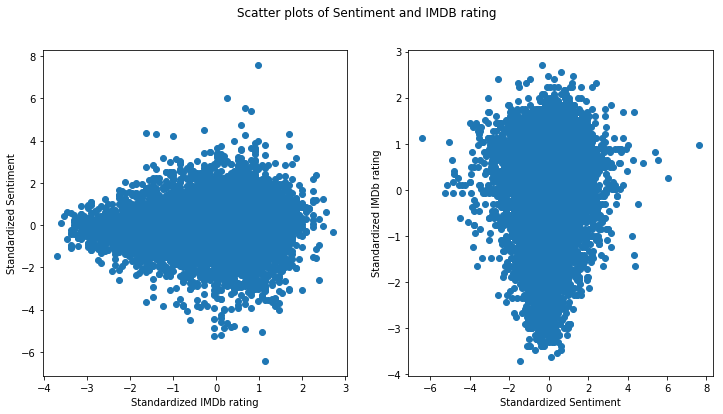

The correlation coeffiecent for the standardized sentiment compared to the standardized rating is 0.082730


In [78]:
#Calculate correlation
y = [moviesentement[key][1]/moviesentement[key][0] for key in ratingDict]
x = ratingDict.values()
y = (y-np.mean(y))/np.std(y)
x = (x-np.mean(x))/np.std(x)
figure = plt.figure(figsize=(12,6))
figure.suptitle("Scatter plots of Sentiment and IMDB rating")
plt.subplot(1,2,1)
plt.scatter(x,y)
plt.xlabel("Standardized IMDb rating")
plt.ylabel("Standardized Sentiment")
plt.subplot(1,2,2)
plt.scatter(y,x)
plt.ylabel("Standardized IMDb rating")
plt.xlabel("Standardized Sentiment")
plt.savefig("Figures/CorrelationSentiment.png")
plt.savefig("Figures/CorrelationSentiment.eps")
plt.savefig("Figures/CorrelationSentiment.svg")
plt.savefig("Figures/CorrelationSentiment.pdf")
plt.show()
print "The correlation coeffiecent for the standardized sentiment compared to the standardized rating is %f" %np.corrcoef(x,y)[0][1]

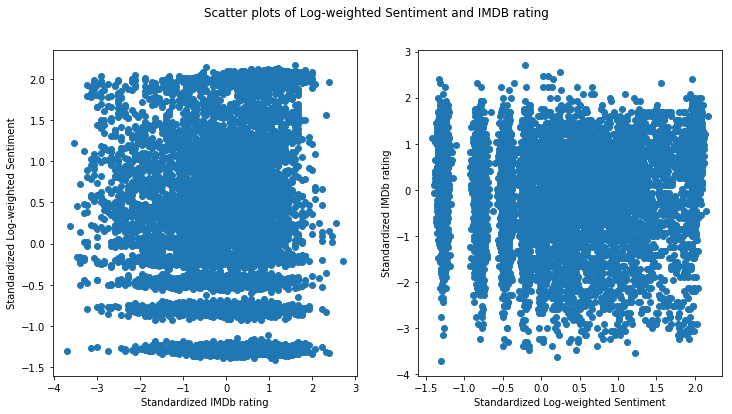

The correlation coeffiecent for the standardaized and log weighted sentiment compared to the standardized rating is -0.049917


In [79]:
#Calculate correlation with log weight
y = [moviesentement[key][1]/moviesentement[key][0]*np.log(moviesentement[key][0]+1) for key in ratingDict]
x = ratingDict.values()
y = (y-np.mean(y))/np.std(y)
x = (x-np.mean(x))/np.std(x)
figure = plt.figure(figsize=(12,6))
figure.suptitle("Scatter plots of Log-weighted Sentiment and IMDB rating")
plt.subplot(1,2,1)
plt.scatter(x,y)
plt.xlabel("Standardized IMDb rating")
plt.ylabel("Standardized Log-weighted Sentiment")
plt.subplot(1,2,2)
plt.scatter(y,x)
plt.ylabel("Standardized IMDb rating")
plt.xlabel("Standardized Log-weighted Sentiment")
plt.savefig("Figures/CorrelationSentimentLog.png")
plt.savefig("Figures/CorrelationSentimentLog.eps")
plt.savefig("Figures/CorrelationSentimentLog.svg")
plt.savefig("Figures/CorrelationSentimentLog.pdf")
plt.show()
print "The correlation coeffiecent for the standardaized and log weighted sentiment compared to the standardized rating is %f" %np.corrcoef(x,y)[0][1]

What we see as now assumed is that rating and sentiment are in no way correlated with or without weighting. This confirms our suspision that the average sentiment of reviews does not reflect if a movie is bad or good.